# Lecture 15: Nanoparticle Shape and Simulated Annealing

## Learning Objectives

By the end of this lecture, you should be able to

1. Describe how the shape of nanoparticles influences their physical, chemical, and mechanical properties.
2. Explain the principles of simulated annealing and how it can be used to find the optimal shape of a nanoparticle.
3. Implement simulated annealing to optimize a system of interacting particles.

## Nanoparticle Shape

The shape of a nanoparticle plays a crucial role in determining its properties. Due to their small size and high surface-to-volume ratio, nanoparticles exhibit unique behaviors compared to bulk materials. The shape can affect

- **Optical Properties**: Nanoscale boundary conditions can lead to quantum confinement effects, altering the optical absorption and emission spectra.
- **Mechanical Properties**: The truncation of long-range interactions and the presence of surface atoms can change the stiffness and strength of nanoparticles.
- **Chemical Properties**: The number and arrangement of surface atoms influence reactivity and catalytic activity.

Understanding and controlling nanoparticle shape is essential for applications in drug delivery, catalysis, photonics, and materials science.

## Local vs. Global Geometry Optimization

When optimizing the geometry of a nanoparticle or any complex system, we aim to find the configuration that minimizes the system's potential energy. However, potential energy surfaces often contain multiple local minima due to the complex interactions between particles. **Local optimization algorithms**, such as gradient descent or methods implemented in [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html#local-multivariate-optimization), can efficiently find a nearby minimum but may get trapped in a local minimum rather than finding the global minimum.

![Illustration of Local vs. Global Minima](local_minimum.png)

In the figure above, a local optimization algorithm starting at $\mathbf{3.5}$ may converge to the local minimum at $\color{red} \mathbf{2}$, missing the global minimum at $\color{blue} \mathbf{-2}$.

## Simulated Annealing

To overcome the limitations of local optimization, we use **global optimization algorithms** that can escape local minima. **Simulated annealing** is a probabilistic technique inspired by the annealing process in metallurgy, where controlled cooling allows atoms to reach lower energy states.

### Principles of Simulated Annealing

Simulated annealing adapts the Metropolis-Hastings algorithm from statistical mechanics. The key steps are:

1. **Initialization**: Start with an initial configuration and a high "temperature" parameter.
2. **Temperature Schedule**: Define a cooling schedule to gradually reduce the temperature.
3. **Generation of New Configurations**: At each step, generate a new configuration by making a random change to the current configuration.
4. **Energy Calculation**: Compute the change in energy, $\Delta E$, between the new and current configurations.
5. **Acceptance Criterion**: Accept the new configuration with probability

   $$
   P(\text{accept}) =
   \begin{cases}
   1, & \text{if } \Delta E \leq 0 \\
   \exp\left(-\dfrac{\Delta E}{k_B T}\right), & \text{if } \Delta E > 0
   \end{cases}
   $$

   where $k_\text{B}$ is the Boltzmann constant, and $T$ is the current temperature.

By allowing occasional uphill moves (accepting higher energy states), the algorithm can escape local minima and explore the configuration space more thoroughly.

## Example: Optimizing the Shape of a Nanoparticle

### Problem Statement

We will optimize the configuration of a cluster of five argon atoms interacting via the Lennard-Jones potential. One atom is fixed at the origin, and the other four are free to move. Our goal is to find the arrangement that minimizes the total potential energy.

### The Lennard-Jones Potential

The Lennard-Jones (LJ) potential models the interaction between a pair of neutral atoms or molecules

$$
V_{\text{LJ}}(r) = 4\varepsilon \left[ \left( \dfrac{\sigma}{r} \right)^{12} - \left( \dfrac{\sigma}{r} \right)^{6} \right]
$$

where $r$ is the distance between two particles, $\varepsilon$ is the depth of the potential well (interaction strength), and $\sigma$ is the finite distance at which the inter-particle potential is zero.

### Implementing the Potential Energy Function

In [1]:
import numpy as np

def lennard_jones(r, epsilon=0.0103, sigma=3.4):
    """
    Calculate the Lennard-Jones potential energy between two particles.
    Parameters:
        r (float): Distance between two particles.
        epsilon (float): Depth of the potential well (eV).
        sigma (float): Finite distance at which the inter-particle potential is zero (Angstrom).
    Returns:
        float: Potential energy (eV).
    """
    return 4 * epsilon * ((sigma / r) ** 12 - (sigma / r) ** 6)

We also need a function to compute the total potential energy of the system:

In [2]:
def total_potential_energy(positions, epsilon=0.0103, sigma=3.4):
    """
    Calculate the total potential energy of the system of particles.
    Parameters:
        positions (ndarray): Array of particle positions with shape (N, 3).
        epsilon (float): Depth of the potential well (eV).
        sigma (float): Finite distance at which the inter-particle potential is zero (Angstrom).
    Returns:
        float: Total potential energy (eV).
    """
    energy = 0.0
    num_particles = len(positions)
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            r = np.linalg.norm(positions[i] - positions[j])
            if r > 0:
                energy += lennard_jones(r, epsilon, sigma)
    return energy

### Simulated Annealing Algorithm

Now, we implement the simulated annealing algorithm to optimize the particle positions.

In [3]:
def simulated_annealing(positions, initial_temp, cooling_rate, num_steps, freeze_particle=0, epsilon=0.0103, sigma=3.4):
    """
    Perform simulated annealing to optimize the nanoparticle configuration.
    Parameters:
        positions (ndarray): Initial positions of the particles.
        initial_temp (float): Initial temperature (arbitrary units).
        cooling_rate (float): Multiplicative factor for cooling (0 < cooling_rate < 1).
        num_steps (int): Number of simulation steps.
        freeze_particle (int): Index of the particle to keep fixed.
        epsilon (float): Depth of the potential well (eV).
        sigma (float): Finite distance at which the inter-particle potential is zero (Angstrom).
    Returns:
        best_positions (ndarray): Optimized positions of the particles.
        best_energy (float): Total potential energy of the optimized configuration.
        energy_history (list): List of energy values over time.
        temp_history (list): List of temperature values over time.
    """
    positions = positions.copy()
    num_particles = len(positions)
    temperature = initial_temp
    best_positions = positions.copy()
    best_energy = total_potential_energy(positions, epsilon, sigma)
    energy_history = []
    temp_history = []
    kB = 8.617333262145e-5  # Boltzmann constant in eV/K

    for step in range(num_steps):
        # Select a random particle to move, excluding the frozen one
        move_particle = np.random.choice([i for i in range(num_particles) if i != freeze_particle])

        # Propose a new position by making a small random displacement
        displacement = np.random.normal(0, 0.1, size=3)
        new_positions = positions.copy()
        new_positions[move_particle] += displacement

        # Compute energies
        current_energy = total_potential_energy(positions, epsilon, sigma)
        new_energy = total_potential_energy(new_positions, epsilon, sigma)
        delta_energy = new_energy - current_energy

        # Acceptance probability
        if delta_energy < 0 or np.random.rand() < np.exp(-delta_energy / (kB * temperature)):
            positions = new_positions
            current_energy = new_energy
            if new_energy < best_energy:
                best_energy = new_energy
                best_positions = new_positions.copy()

        # Record energy and temperature
        energy_history.append(current_energy)
        temp_history.append(temperature)

        # Update temperature
        temperature *= cooling_rate

    return best_positions, best_energy, energy_history, temp_history

### Running the Simulation

Set up the initial positions and parameters, and run the simulated annealing algorithm.

In [4]:
np.random.seed(42)

# Lennard-Jones parameters for Argon
epsilon = 0.0103  # eV
sigma = 3.4  # Angstrom
r_min = 2 ** (1 / 6) * sigma  # Distance at minimum potential

# Initial positions (one fixed at the origin)
positions = np.array([
    [0.0, 0.0, 0.0],  # Fixed particle
    [r_min, 0.0, 0.0],
    [0.0, r_min, 0.0],
    [0.0, 0.0, r_min],
    [r_min, r_min, r_min]
])

# Simulated annealing parameters
initial_temp = 1000.0  # Initial temperature in K
cooling_rate = 0.999  # Closer to 1 means slower cooling
num_steps = 10000

# Run simulated annealing
best_positions, best_energy, energy_history, temp_history = simulated_annealing(
    positions,
    initial_temp,
    cooling_rate,
    num_steps,
    freeze_particle=0,
    epsilon=epsilon,
    sigma=sigma
)

### Visualizing the Results

Plot the total potential energy and temperature over the simulation steps.

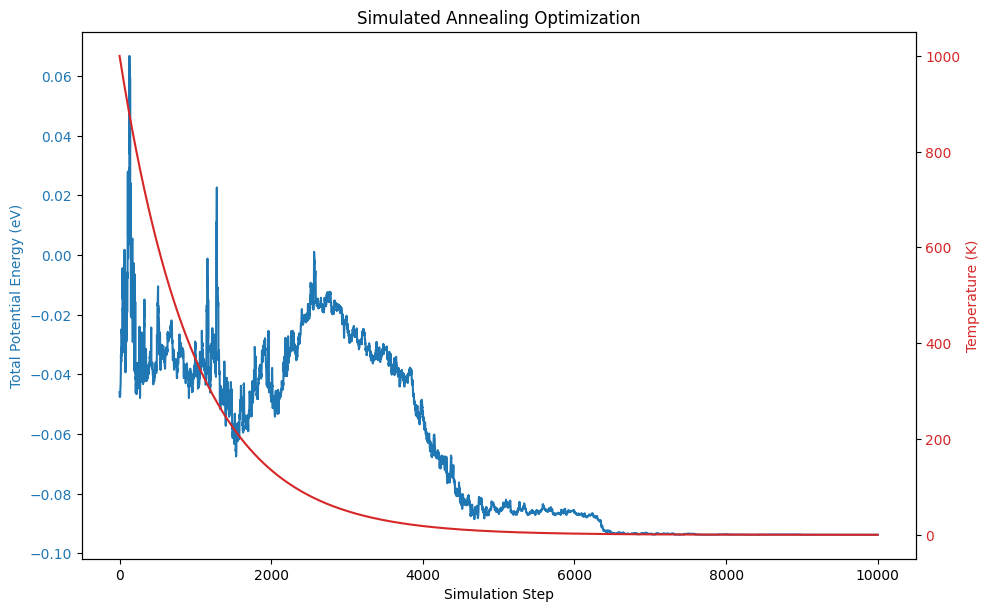

In [5]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(10, 6))

color_energy = 'tab:blue'
ax1.set_xlabel('Simulation Step')
ax1.set_ylabel('Total Potential Energy (eV)', color=color_energy)
ax1.plot(energy_history, color=color_energy)
ax1.tick_params(axis='y', labelcolor=color_energy)

ax2 = ax1.twinx()  # Instantiate a second axes that shares the same x-axis

color_temp = 'tab:red'
ax2.set_ylabel('Temperature (K)', color=color_temp)
ax2.plot(temp_history, color=color_temp)
ax2.tick_params(axis='y', labelcolor=color_temp)

fig.tight_layout()
plt.title('Simulated Annealing Optimization')
plt.show()

```{admonition} Interpretation
:class: tip
The plot shows how the total potential energy of the system decreases over time as the simulated annealing algorithm progresses. Initially, at high temperatures, the system explores a wide range of configurations, allowing for higher energy states. As the temperature decreases, the acceptance of higher energy states becomes less probable, and the system gradually settles into lower energy configurations. The energy curve shows fluctuations corresponding to accepted uphill moves, but overall trends downward, indicating convergence towards the global minimum.
```

### Analyzing the Optimized Configuration

Let's output the optimized positions and visualize the final configuration.

In [6]:
# Print the optimized configuration in XYZ format
print(f"{len(best_positions)}")
print("Optimized configuration of the nanoparticle")
for position in best_positions:
    print(f"Ar {position[0]:.6f} {position[1]:.6f} {position[2]:.6f}")

5
Optimized configuration of the nanoparticle
Ar 0.000000 0.000000 0.000000
Ar 3.716731 -0.614456 0.409582
Ar 2.098210 2.422874 2.062186
Ar 1.364967 -1.077208 3.395846
Ar 4.810169 0.456312 3.873756


You can save this output to an `.xyz` file and visualize it using molecular visualization software like VESTA or Avogadro.

![Optimized configuration of the nanoparticle](Ar5.png)

```{admonition} Interpretation
:class: tip
The optimized configuration shows the five argon atoms arranged in a trigonal bipyramidal structure. This geometry minimizes the total potential energy by optimizing the distances between particles to balance attractive and repulsive forces as defined by the Lennard-Jones potential. Each atom (except the fixed one) adjusts its position to achieve the most energetically favorable arrangement.
```

## Exercise

1. **Parameter Exploration**: Modify the simulated annealing parameters (`initial_temp`, `cooling_rate`, `num_steps`) to observe their effects on the optimization process. How does changing the cooling rate affect the convergence?
2. **Alternative Optimization Methods**: Implement a different global optimization algorithm, such as Differential Evolution or Basin Hopping from [`scipy.optimize`](https://docs.scipy.org/doc/scipy/reference/optimize.html#global-optimization). Compare the results and efficiency with simulated annealing.
3. **Scaling Up**: Increase the number of particles (e.g., to 10 or 20) and observe how the optimization process scales with system size. What challenges arise with larger systems?
4. **Potential Function Variation**: Try using a different interatomic potential, such as the Morse potential. How does the choice of potential affect the optimized configuration?

## Summary

In this lecture, we explored the significance of nanoparticle shape in determining their properties and learned how global optimization algorithms like simulated annealing can be employed to find optimal configurations. Simulated annealing mimics the physical process of annealing, allowing the system to escape local minima and converge towards the global minimum by controlled cooling. By implementing this algorithm, we optimized a small cluster of Lennard-Jones particles, demonstrating its effectiveness in solving complex optimization problems in the chemical sciences.